# scalar_highres

Sample code for implementing high-resolution wave propagation methods for scalar nonlinear conservation laws.

This version only implements upwind.  Homework 4 requires adding LW, minmod, and MC methods.

The examples currently included are all for Burgers' equation, but the method should work for other convex fluxes $f(q)$.  You just need to define the flux function and the sonic point `qsonic` where $f'(q_s) = 0$ (if there is one; if not then the "entropy fix" is never needed).

In [247]:
%matplotlib inline

In [248]:
from pylab import *

In [249]:
from IPython.display import HTML

In [250]:
try:
    from clawpack.visclaw import animation_tools
except:
    print("Failed to load animation_tools from Clawpack")

### Set the flux and sonic point for Burgers' equation

In [251]:
f_burgers = lambda q: 0.5*q**2
qsonic_burgers = 0.

We now set up a grid with 2 ghost cells on each side, as needed in general for high-resolution methods with limiters.

Note that only one ghost cell is needed for the data that goes into the Riemann problems we need solve for the Godunov update in the interior, but in order to limit the resulting waves based on looking at the neighboring Riemann problem on the upwind side, we need to solve an additional Riemann problem requiring another ghost cell for its data. 

In [252]:
xlower = 0.
xupper = 1.
num_cells = 20
dx = (xupper - xlower)/num_cells

# cell centers, including two ghost cells on either side:
x = arange(xlower-3*dx/2, xupper+2*dx, dx)

# interior grid cells are numbered 2,3,...num_cells+1
# define array of indices of interior cells for vectorized methods:
ii = array(range(2,num_cells+2), dtype=int)  

print('including 4 ghost cells, the grid has %i cells' % len(x))
print('cell centers: \n',x)

including 4 ghost cells, the grid has 24 cells
cell centers: 
 [-0.075 -0.025  0.025  0.075  0.125  0.175  0.225  0.275  0.325  0.375
  0.425  0.475  0.525  0.575  0.625  0.675  0.725  0.775  0.825  0.875
  0.925  0.975  1.025  1.075]


In [253]:
def highres_step(x,Qn,dt,f,qsonic,method,efix):
    """
    High-resolution method for the scalar equation, written
    in a more general form similar to the methods described in
    Section 12.8 of FVMHP for nonlinear scalar equations.
    
    f should be a function defining the flux f(q).
    qsonic should be the sonic point where f'(qsonic) = 0.
    If there is no sonic, point, this 
    
    method can be
        'upwind', 'LW', 'minmod', or 'MC'
    in this version.
    
    If efix == True, use the correct Godunov flux in the transonic
    rarefaction case, otherwise always use the jump in Q as the wave
    with speed from the Rankine-Hugoniot condition.
    """
    
    num_cells = len(Qn) - 4
    dx = x[1] - x[0]  # assuming uniform grid
    
    #indices of interior grid cells (not including ghost cells)
    ii = array(range(2,num_cells+2), dtype=int) 
        
    Qnp = Qn.copy()
    
    if False:
        # periodic BCs with two ghost cells on each side
        Qn[0] = Qn[-4]
        Qn[1] = Qn[-3]
        Qn[-2] = Qn[2]
        Qn[-1] = Qn[3]
    
    # extrapolation (outflow) boundary conditions:
    Qn[0] = Qn[2]
    Qn[1] = Qn[2]
    Qn[-2] = Qn[-3]
    Qn[-1] = Qn[-3]
    
   
    # Note below: waves, speeds, Qimh, etc are only 
    # defined for cells that have an interface to left

    # waves:
    wave = zeros(x.shape)
    wave[1:] = Qn[1:] - Qn[0:-1]  
    
    # speeds:  (using Rankine-Hugoniot relation)
    Fn = f(Qn)
    dq = zeros(x.shape)
    dq[1:] = Qn[1:] - Qn[:-1]
    df = zeros(x.shape)
    df[1:] = Fn[1:] - Fn[:-1]
    s = zeros(x.shape)
    # avoid divide-by-zero in computing df/dq:
    s[1:] = divide(df[1:], dq[1:], where=dq[1:]!=0, out=zeros(dq[1:].shape))

    # fluctuations (12.8) in FVMHP
    amdq = where(s<0, s*wave, 0.)
    apdq = where(s>0, s*wave, 0.)
    
    if efix:
        # Implements the proper way to define all F_{i-1/2} from (12.2) for Godunov.
        # This should agree with the above except for sonic rarefaction case
  
        # interface fluxes before applying entropy fix:
        Fimh = zeros(x.shape)
        Fimh[2:] = where(s[2:]<0, Fn[2:], Fn[1:-1])  # f(Qn) from upwind side
        
        # check for sonic point between states:
        # if  (f(q_{i-1)-f(qsonic))/(q_{i-1-qsonic) < 0
        # and (f(q_i)-f(qsonic))/(q_i-qsonic) >0
        # then there is a transonic rarefaction and F_{i-1/2} = f(qsonic)
        fsonic = f(qsonic)
        dq[1:] = Qn[1:] - qsonic
        df[1:] = Fn[1:] - fsonic
        # slopes to compare:
        Fs = zeros(x.shape)
        Fs[1:] = divide(df[1:], dq[1:], where=dq[1:]!=0, out=zeros(dq[1:].shape))
        
        # apply the entropy fix:
        Fimh[2:] = where(logical_and(Fs[1:-1]<0, Fs[2:]>0), fsonic, Fimh[2:])
        amdq[1:] = Fimh[1:] - Fn[:-1]
        apdq[1:] = Fn[1:] - Fimh[1:]
    
    # Godunov step: propagate waves to update the proper cell:
    Qnp[ii] = Qnp[ii] - dt/dx * apdq[ii]    # right-going
    Qnp[ii] = Qnp[ii] - dt/dx * amdq[ii+1]  # left-going
    
    if method == 'upwind':
        # for upwind, zero out all waves in high-resolution correction terms:
        wlimiter = zeros(wave.shape)
    elif method == 'LW':
        # Lax-Wendroff, use full wave:
        wlimiter = ones(wave.shape)
    else:
        # compute things needed for any limiter:
        
        # the wave from the neighboring Riemann problem on upwind side:
        wave_upwind = zeros(x.shape)
        wave_upwind[2:-1] = where(s[2:-1]>0, wave[1:-2], wave[3:])
        
        # compute ratio theta = wave_upwind/wave, returning 0 where wave==0:
        # using the numpy.divide function this way avoids divide-by-zero
        theta = divide(wave_upwind, wave, where=wave!=0, out=zeros(wave.shape))
        
        if method == 'minmod':
            wlimiter = maximum(0., minimum(1., theta))
        elif method == 'MC':
            wlimiter = maximum(0., minimum(minimum(2., (1+theta)/2),2*theta))
        else:
            print('method %s is not implemented, using upwind' % method)
            wlimiter = zeros(wave.shape)
        
    Wtilde = wlimiter * wave
    
    # correction fluxes:
    Ftilde = zeros(x.shape)
    Ftilde[1:-1] = 0.5*abs(s[1:-1])*(1 - abs(s[1:-1])*dt/dx) * Wtilde[1:-1]
    
    # update cells by flux differencing Ftilde:
    Qnp[ii] = Qnp[ii] - dt/dx * (Ftilde[ii+1] - Ftilde[ii])

    return Qnp

In [254]:
def time_stepper(t0, x, Q0, dt, nsteps, f, qsonic, one_step, method, efix):
    """
    Take nsteps with time step dt, starting with initial data Q0 at time t0.
    To take a single step use the method specified by one_step, which
    defaults to Godunov_step since that is the only method currently defined.
    But you might want to define a new method for comparison.
    """
    Qn = Q0.copy()
    for n in range(nsteps):
        Qn = one_step(x, Qn, dt, f, qsonic, method, efix)
    return Qn

In [255]:
def plotQ(x, Qn, tn):
    # only plot the interior points:
    plot(x[2:-3], Qn[2:-3], 'bo-', markersize=4)
    grid(True)
    xlim(xlower, xupper)
    ylim(-2,2)
    title('Time t = %.3f' % tn)

In [256]:
#modify to change axis limits
def plotQ1(x, Qn, tn):
    # only plot the interior points:
    plot(x[2:-3], Qn[2:-3], 'bo-', markersize=4)
    grid(True)
    xlim(xlower, xupper)
    ylim(-1,6)
    title('Time t = %.3f' % tn)

## Example usage

Using dt = 0.0040, taking 40 steps to time 0.160


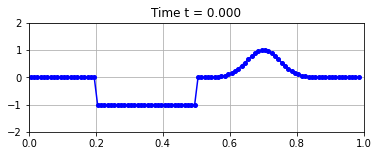

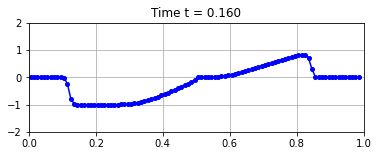

In [257]:
num_cells = 100
dx = (xupper - xlower)/num_cells
# cell centers, including two ghost cells on either side:
x = arange(xlower-3*dx/2, xupper+2*dx, dx)

t0 = 0.
Q0 = where(logical_and(x>0.2,x<0.5), -1., 0.) \
     + exp(-200*(x-0.7)**2)

tn = 0.
figure(figsize=(6,2))
plotQ(x,Q0,t0)

dt = 0.004
nsteps = 40
tn = t0 + nsteps*dt
print('Using dt = %.4f, taking %i steps to time %.3f' \
      % (dt,nsteps,tn))

Qn = time_stepper(t0, x, Q0, dt, nsteps, f_burgers, qsonic_burgers, highres_step, 'upwind', True)
fig = figure(figsize=(6,2))
plotQ(x,Qn,tn)

## Make an animated version:

In [258]:
def make_anim(t0, x, Q0, dt, nsteps, nplot, f, qsonic, one_step, method, efix):
    
    Qn = Q0.copy()  
    
    figsize = (6,4)
    figs = []  # to accumulate figures for animation
         
    # plot initial data:
    fig = figure(figsize=figsize)
    plotQ(x,Q0,t0)
    title('t = %.3f, %s, efix = %s' % (t0,method,efix))
    figs.append(fig)
    close(fig)

    for n in range(1,nsteps+1):
        # take the next step
        Qn = highres_step(x, Qn, dt, f, qsonic, method, efix)
        tn = n*dt
        if mod(n,nplot)==0:
            fig = figure(figsize=figsize)
            plotQ(x,Qn,tn)
            title('t = %.3f, %s, efix = %s' % (tn,method,efix))
            figs.append(fig)
            close(fig)
            
    anim = animation_tools.animate_figs(figs, figsize=figsize)
    return anim

## Sample animation

In [259]:
num_cells = 50
dx = (xupper - xlower)/num_cells
# cell centers, including two ghost cells on either side:
x = arange(xlower-3*dx/2, xupper+2*dx, dx)

Q0 = where(logical_and(x>0.2,x<0.5), -1., 0.) \
     + exp(-200*(x-0.7)**2)

t0 = 0.
dt = 0.5*dx  # should be stable on Burgers' for |q| <= 2
tfinal = 1.0
# choose number of steps to roughly hit tfinal
nsteps = int(round(tfinal / dt)) + 1
# with 10 frames in animation
nplot = int(round(nsteps/10)) 
print('tfinal = %.2f, dt = %.3f, nsteps = %i' % (tfinal, dt, nsteps))

anim = make_anim(t0, x, Q0, dt, nsteps, nplot, f_burgers, qsonic_burgers,
                 highres_step, 'upwind', True)
HTML(anim.to_jshtml())

tfinal = 1.00, dt = 0.010, nsteps = 101


## Run some tests for Riemann problem initial data

For illustration purposes, hard-wire some things to make it easy to try different Riemann problems as initial data for the numerical method.

For the Riemann problem, we can use formula (16.7) in FVMHP to compute the exact solution for comparison purposes.  (Also works for nonconvex f.)

In [260]:
def osher_solution(f, q_left, q_right, n=1000):
    """
    Compute the Riemann solution to a scalar conservation law.
    Assumes a jump discontinuity from q_left to q_right at x=0.
    Then the solution is a similarity solution.
    
    Uses Osher's formula (16.7) in FVMHP.
    
    Input:
      f = flux function (possibly nonconvex)
      q_left, q_right = Riemann data
      n = number of points for evaluating f(q) between q_left,q_right
          in order to approximate argmin function.
      
    Returns:
      qtilde = function of xi = x/t giving the Riemann solution
    """

    from numpy import linspace,empty,argmin,argmax
    
    q_min = min(q_left, q_right)
    q_max = max(q_left, q_right)
    qv = linspace(q_min, q_max, n)
    
    # define the function qtilde as in (16.7)
    if q_left <= q_right:
        def qtilde(xi):
            Q = empty(xi.shape, dtype=float)
            for j,xij in enumerate(xi):
                i = argmin(f(qv) - xij*qv)
                Q[j] = qv[i]
            return Q
    else:
        def qtilde(xi):
            Q = empty(xi.shape, dtype=float)
            for j,xij in enumerate(xi):
                i = argmax(f(qv) - xij*qv)
                Q[j] = qv[i]
            return Q
    
    return qtilde

### Function to test out a method on a specific Riemann problem

In [261]:
def test_rp(x0, qleft, qright, method, efix):
    
  #  if method != 'upwind':
   #     print('Only upwind is implemented!')
    #    return
    
    num_cells = 50
    dx = (xupper - xlower)/num_cells
    # cell centers, including two ghost cells on either side:
    x = arange(xlower-3*dx/2, xupper+2*dx, dx)
    Q0 = where(x<x0, qleft, qright)
    
    dt = 0.5*dx  # should be stable on Burgers' for |q| <= 2

    t0 = 0.
    tfinal = 0.5
    # choose number of steps to roughly hit tfinal
    nsteps = int(round(tfinal / dt))
    print('tfinal = %.2f, dt = %.3f, nsteps = %i' % (tfinal, dt, nsteps))
    
    figure(figsize=(6,2))
    plotQ(x,Q0,t0)
    
    xfine = linspace(xlower, xupper, 1000)
    q0fine = where(xfine<x0, qleft, qright)
    plot(xfine, q0fine, 'r')

    Qn = time_stepper(t0, x, Q0, dt, nsteps, f_burgers, qsonic_burgers,
                      highres_step, method, efix)
    fig = figure(figsize=(6,2))
    plotQ(x,Qn,tfinal)
    
    qtilde = osher_solution(f_burgers, qleft, qright)
    plot(xfine, qtilde((xfine-x0)/tfinal), 'r')


tfinal = 0.50, dt = 0.010, nsteps = 50


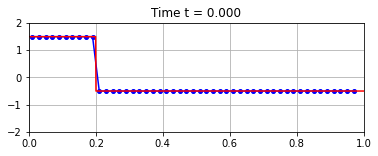

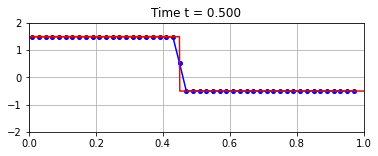

In [262]:
test_rp(x0=0.2, qleft=1.5, qright=-0.5, method = 'upwind', efix = False)

tfinal = 0.50, dt = 0.010, nsteps = 50


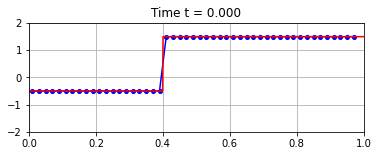

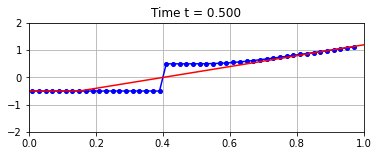

In [263]:
test_rp(x0=0.4, qleft=-0.5, qright=1.5, method = 'upwind', efix = False)

tfinal = 0.50, dt = 0.010, nsteps = 50


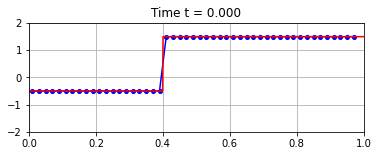

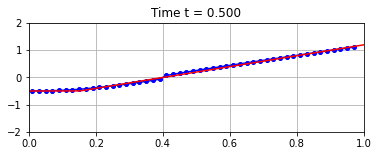

In [264]:
test_rp(x0=0.4, qleft=-0.5, qright=1.5, method = 'upwind', efix = True)

tfinal = 0.50, dt = 0.010, nsteps = 50


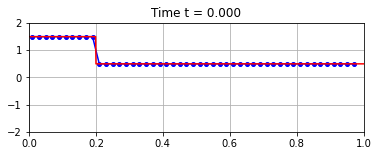

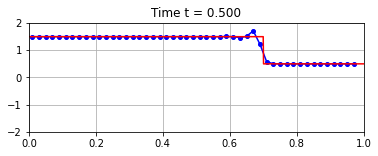

In [265]:
test_rp(x0=0.2, qleft=1.5, qright=0.5, method = 'LW', efix = False)

tfinal = 0.50, dt = 0.010, nsteps = 50


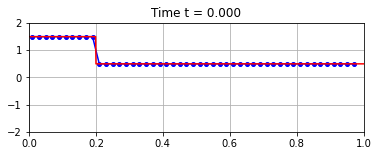

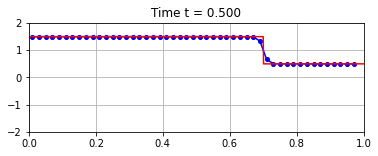

In [266]:
test_rp(x0=0.2, qleft=1.5, qright=0.5, method = 'minmod', efix = False)

tfinal = 0.50, dt = 0.010, nsteps = 50


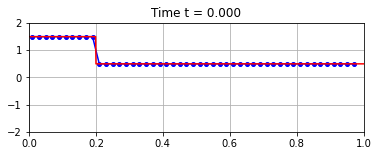

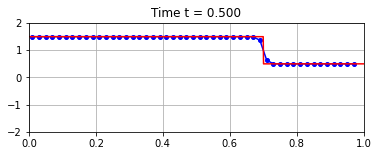

In [267]:
test_rp(x0=0.2, qleft=1.5, qright=0.5, method = 'MC', efix = False)

tfinal = 0.50, dt = 0.010, nsteps = 50


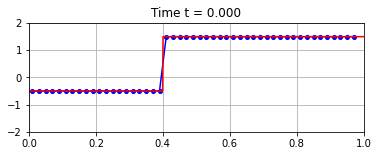

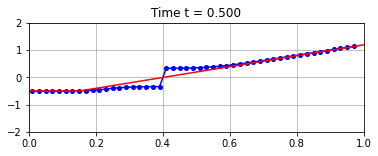

In [268]:
test_rp(x0=0.4, qleft=-0.5, qright=1.5, method = 'minmod', efix = False)

tfinal = 0.50, dt = 0.010, nsteps = 50


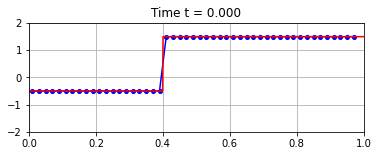

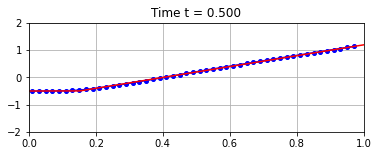

In [269]:
test_rp(x0=0.4, qleft=-0.5, qright=1.5, method = 'minmod', efix = True)

tfinal = 0.50, dt = 0.010, nsteps = 50


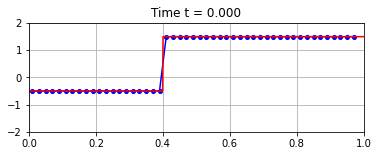

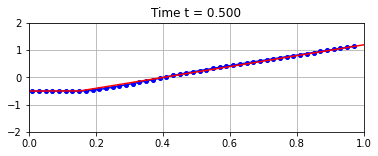

In [270]:
test_rp(x0=0.4, qleft=-0.5, qright=1.5, method = 'MC', efix = False)

tfinal = 0.50, dt = 0.010, nsteps = 50


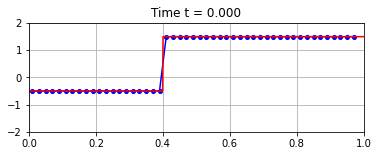

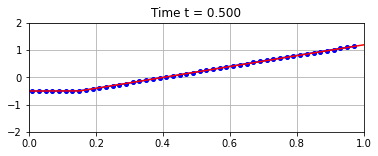

In [271]:
test_rp(x0=0.4, qleft=-0.5, qright=1.5, method = 'MC', efix = True)

## Function to test a method on Riemann problem with general flux (no sonic point)

In [272]:
def test_rpf(f,x0, qleft, qright, method):
    
  #  if method != 'upwind':
   #     print('Only upwind is implemented!')
    #    return
    
    num_cells = 50
    dx = (xupper - xlower)/num_cells
    # cell centers, including two ghost cells on either side:
    x = arange(xlower-3*dx/2, xupper+2*dx, dx)
    Q0 = where(x<x0, qleft, qright)
    
    dt = dx/exp(5) #works if q<5

    t0 = 0.
    tfinal = 0.03
    # choose number of steps to roughly hit tfinal
    nsteps = int(round(tfinal / dt))
    print('tfinal = %.2f, dt = %.3f, nsteps = %i' % (tfinal, dt, nsteps))
    
    figure(figsize=(6,2))
    plotQ1(x,Q0,t0)
    
    xfine = linspace(xlower, xupper, 1000)
    q0fine = where(xfine<x0, qleft, qright)
    plot(xfine, q0fine, 'r')

    Qn = time_stepper(t0, x, Q0, dt, nsteps, f, 0.,
                      highres_step, method, False)
    fig = figure(figsize=(6,2))
    plotQ1(x,Qn,tfinal)
    
    qtilde = osher_solution(f, qleft, qright)
    plot(xfine, qtilde((xfine-x0)/tfinal), 'r')


In [273]:
newf = lambda q: exp(q)

Here, we apply the minmod limiter to the additional problem.

tfinal = 0.03, dt = 0.000, nsteps = 223


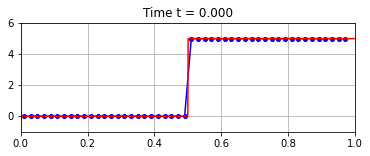

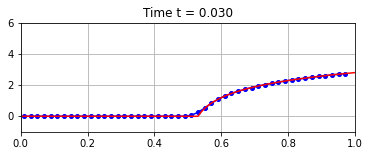

In [274]:
test_rpf(newf,x0=0.5, qleft=0., qright=5., method = 'minmod')

## Animated version of Riemann problem examples

These animations were used in the video FVMHP14.

In [275]:
def make_anim_rp(x0, qleft, qright, f=f_burgers, qsonic=qsonic_burgers, method='upwind', efix=True):
    
    
    xfine = linspace(xlower, xupper, 1000)
    qtilde = osher_solution(f, qleft, qright)
    
    num_cells = 50
    dx = (xupper - xlower)/num_cells
    # cell centers, including two ghost cells on either side:
    x = arange(xlower-3*dx/2, xupper+2*dx, dx)
    Q0 = where(x<x0, qleft, qright)
    
    dt = 0.5*dx  # should be stable on Burgers' for |q| <= 2

    t0 = 0.
    tfinal = 1.0
    # choose number of steps to roughly hit tfinal
    nsteps = int(round(tfinal / dt))
    print('tfinal = %.2f, dt = %.3f, nsteps = %i' % (tfinal, dt, nsteps))

    Qn = Q0.copy()  
    
    figsize = (6,4)
    figs = []  # to accumulate figures for animation
    
    # plot initial data:
    fig = figure(figsize=figsize)
    plotQ(x,Q0,t0)
    q0fine = where(xfine<x0, qleft, qright)
    plot(xfine, q0fine, 'r')
    title('t = %.3f, %s, efix = %s' % (t0,method,efix))
    figs.append(fig)
    close(fig)

    for n in range(1,nsteps+1):
        # take the next step
        Qn = highres_step(x, Qn, dt, f, qsonic, method, efix)
        tn = n*dt
        if mod(n,nplot)==0:
            fig = figure(figsize=figsize)
            plotQ(x,Qn,tn)
            plot(xfine, qtilde((xfine-x0)/tn), 'r')
            title('t = %.3f, %s, efix = %s' % (tn,method,efix))
            figs.append(fig)
            close(fig)            

    anim = animation_tools.animate_figs(figs, figsize=figsize)
    return anim

In [276]:
anim = make_anim_rp(x0=0.2, qleft=1.5, qright=0.5, method='upwind', efix=False)
HTML(anim.to_jshtml())

tfinal = 1.00, dt = 0.010, nsteps = 100


In [277]:
anim = make_anim_rp(x0=0.2, qleft=0.5, qright=1.5, method='upwind', efix=False)
HTML(anim.to_jshtml())

tfinal = 1.00, dt = 0.010, nsteps = 100


## Transonic rarefaction

In [278]:
anim = make_anim_rp(x0=0.2, qleft=-0.5, qright=1.5, method='upwind', efix=False)
HTML(anim.to_jshtml())

tfinal = 1.00, dt = 0.010, nsteps = 100


In [279]:
anim = make_anim_rp(x0=0.2, qleft=-0.5, qright=1.5, method='upwind', efix=True)
HTML(anim.to_jshtml())

tfinal = 1.00, dt = 0.010, nsteps = 100


## Lax-Wendroff and high-resolution methods

In [280]:
anim = make_anim_rp(x0=0.2, qleft=0.5, qright=1.5, method='LW', efix=False)
HTML(anim.to_jshtml())

tfinal = 1.00, dt = 0.010, nsteps = 100


In [281]:
anim = make_anim_rp(x0=0.2, qleft=0.5, qright=1.5, method='minmod', efix=False)
HTML(anim.to_jshtml())

tfinal = 1.00, dt = 0.010, nsteps = 100


### Transonic rarefaction

In [282]:
anim = make_anim_rp(x0=0.2, qleft=-0.5, qright=1.5, method='minmod', efix=False)
HTML(anim.to_jshtml())

tfinal = 1.00, dt = 0.010, nsteps = 100


In [283]:
anim = make_anim_rp(x0=0.2, qleft=-0.5, qright=1.5, method='MC', efix=False)
HTML(anim.to_jshtml())

tfinal = 1.00, dt = 0.010, nsteps = 100


In [284]:
anim = make_anim_rp(x0=0.2, qleft=-0.5, qright=1.5, method='minmod', efix=True)
HTML(anim.to_jshtml())

tfinal = 1.00, dt = 0.010, nsteps = 100
